<a href="https://colab.research.google.com/github/priyanshkedia2/fintech_task/blob/main/Fintech_Task02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed


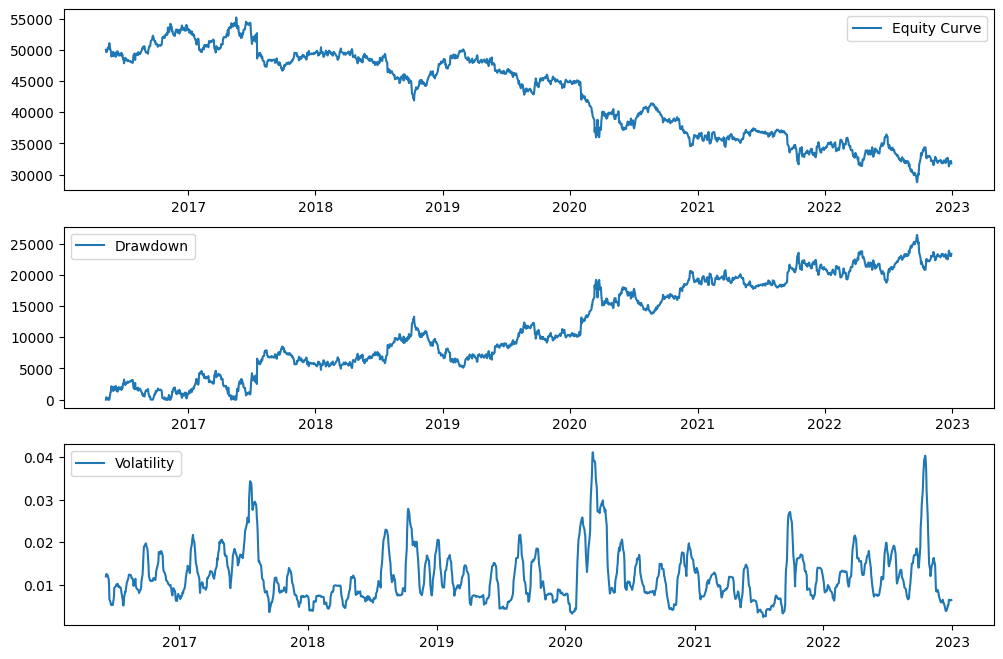

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def calculate_exponential_moving_average(data, window):
    return data['Close'].ewm(span=window, adjust=False).mean()

def calculate_relative_strength_index(data, window):
    price_diff = data['Close'].diff(1)
    gain = price_diff.where(price_diff > 0, 0)
    loss = -price_diff.where(price_diff < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def generate_trading_signals(data, ema_window, rsi_window, rsi_overbought, rsi_oversold):
    signals = pd.DataFrame(index=data.index)
    signals['EMA'] = calculate_exponential_moving_average(data, ema_window)
    signals['RSI'] = calculate_relative_strength_index(data, rsi_window)

    # Generate trading signals
    signals['Signal'] = 0
    signals.loc[signals['EMA'] > data['Close'], 'Signal'] = 1  # Long signal
    signals.loc[signals['EMA'] < data['Close'], 'Signal'] = -1  # Short signal
    signals.loc[(signals['RSI'] > rsi_overbought) & (signals['Signal'] == 1), 'Signal'] = 0  # Exit long
    signals.loc[(signals['RSI'] < rsi_oversold) & (signals['Signal'] == -1), 'Signal'] = 0  # Exit short

    return signals

def backtest_strategy(data, signals, initial_capital=50001, compound=True):
    positions = pd.DataFrame(index=data.index)
    positions['Position'] = signals['Signal']
    positions['Stock'] = 100 * positions['Position']  # Assume 100 shares per trade

    # Calculate daily portfolio value
    portfolio = positions.multiply(data['Close'], axis=0)
    pos_diff = positions.diff()

    # Add cash holdings to the portfolio
    portfolio['Cash'] = initial_capital - (pos_diff['Stock'] * data['Close']).cumsum()

    # Calculate total portfolio value
    portfolio['Total'] = portfolio['Stock'] + portfolio['Cash']

    # Calculate daily returns
    portfolio['Returns'] = portfolio['Total'].pct_change()

    if compound:
        portfolio['Returns'] = (1 + portfolio['Returns']).cumprod() - 1

    return portfolio

# Example usage:
stock_symbol = 'ITC.NS'
start_date = '2016-05-07'
end_date = '2022-12-31'

stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
ema_window = 20
rsi_window = 14
rsi_overbought = 70
rsi_oversold = 30

trading_signals = generate_trading_signals(stock_data, ema_window, rsi_window, rsi_overbought, rsi_oversold)
portfolio_data = backtest_strategy(stock_data, trading_signals)

# Plot equity curve, drawdown chart, and volatility chart
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(portfolio_data['Total'], label='Equity Curve')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(portfolio_data['Total'].cummax() - portfolio_data['Total'], label='Drawdown')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(portfolio_data['Returns'].rolling(window=20).std(), label='Volatility')
plt.legend()

plt.show()